In [1]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import numpy as np
import random
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import r2_score

### Создание датасета:
### Случайный лес не требует тестовых данных. Однако для независимой оценки создадим вилидационные данные:

In [2]:
X, Y, coef = make_regression(n_samples=1000, n_features=5, n_informative=3, noise=0.5, coef=True, random_state=13)

# Добавление в датасет пустых значений - написанный скрипт работает с пустыми значениями
X[300, 0] = None
X[2, 0] = None
X[100, 0] = None
X[700, 1] = None
X[500, 1] = None

# Разбиение на тренировочную и валидационные выборки
x_train, x_validate, y_train, y_validate = train_test_split(X, Y, test_size=0.3, shuffle=True, random_state=13)

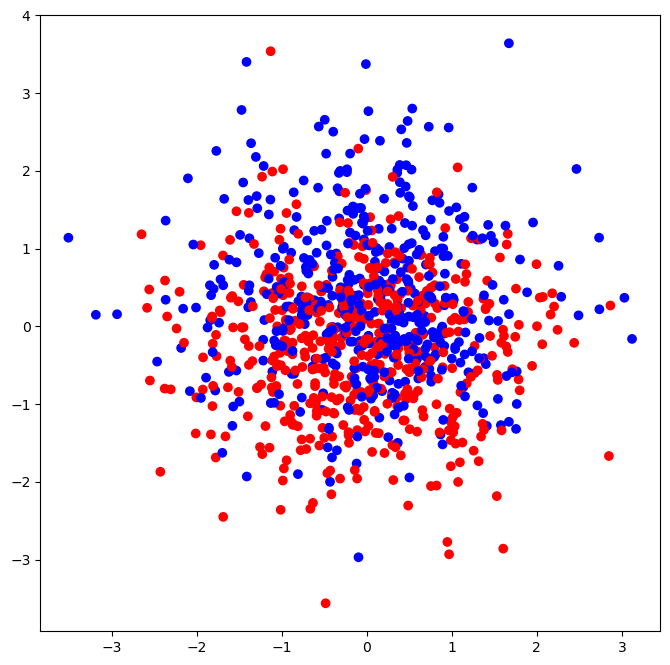

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)), 
              c=Y, cmap=colors)
plt.show()

### Формула расчета критерия информативности для регрессионного дерева решений на основе дисперсии:

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ — среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

### Класс дерева:

In [4]:
class Tree:
    
    def __init__(self, x_train, y_train, x_test, y_test, min_count_of_samples_per_branch=5):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.min_count_of_samples_per_branch = min_count_of_samples_per_branch  
    
    
    # Расчет критерия информативности как дисперсию выборки
    @staticmethod
    def info_criteria(Y):
        mean_y = np.mean(Y)
        result = 0
        for i in range(Y.shape[0]):
            result += (Y[i] - mean_y)**2
        return result / Y.shape[0]
    
    
    
    # Расчет коэффициента качества
    @staticmethod
    def _quality_koef(y_left_branch, y_right_branch, current_info_criteria):

        # Доля выборки, ушедшей в левую ветку
        p = y_left_branch.shape[0] / (y_left_branch.shape[0] + y_right_branch.shape[0])

        # Коэффициент качества
        return current_info_criteria - p * Tree.info_criteria(y_left_branch) - (1-p) * Tree.info_criteria(y_right_branch)
    
    
    
    # Функция разделяет выборку на две ветки: левую и правую.
    # Критерий - сравнение наблюдения в массиве x по индексу index с номинальным t
    # Функция обрабатывает Null - значения из массива x
    @staticmethod
    def _split_branch(x, y, index, t):

        x_left_branch = []
        y_left_branch = []
        x_right_branch = []
        y_right_branch = []

        for i in range(x.shape[0]):

            # Обработка Null - значений:
            if x[i, index] == None:
                x_left_branch.append(x[i, :])
                y_left_branch.append(y[i])
                x_right_branch.append(x[i, :])
                y_right_branch.append(y[i])

            elif x[i, index] <= t:
                x_left_branch.append(x[i, :])
                y_left_branch.append(y[i])

            else:
                x_right_branch.append(x[i, :])
                y_right_branch.append(y[i])

        return np.array(x_left_branch), np.array(y_left_branch), np.array(x_right_branch), np.array(y_right_branch)
    
    
    
    # Макрос поиска наилучшего критерия для разбиения на левую и правую ветки
    @staticmethod
    def _find_best_split(x, y, min_count_of_samples_per_branch):
    # Критерий выбора наилучшего значения: максимальное значение параметра качества - best_quality (прирост информации)
        best_t = None    # Значение параметра t, при котором достигается наилучшее качество (прирост информации)
        best_index = None    # Значение индекса столбца  массива x, при котором достигается наилучшее качество (прирост информации)  
        best_quality = 0    # Переменная, хранящая значения качества (прирост информации)
        current_entropia = Tree.info_criteria(y)    # Переменная, хранящая текущую энтропию для данной выборки

        # Макрос выполняет поиск не по всем признакам выборки, а только по некоторым, выбранным случайно:
        indexes = Tree._get_random_indexes(x)
        
        for index in indexes:
            for row in range(x.shape[0]):
                t = x[row,index]
                x_left_branch, y_left_branch, x_right_branch, y_right_branch = Tree._split_branch(x, y, index, t)

                # Проверка, достаточно ли образцов и листе - борьба с переобучением
                if y_left_branch.shape[0] < min_count_of_samples_per_branch or y_right_branch.shape[0] < min_count_of_samples_per_branch:
                    continue

                # Расчет прироста информации на данной итерации
                current_quality = Tree._quality_koef(y_left_branch, y_right_branch, current_entropia)

                if current_quality > best_quality:
                    best_quality = current_quality
                    best_index = index
                    best_t = x[row,index]

        return best_index, best_t, best_quality       
    
    
    
    # Макрос рекурсивного создания узлов и листьев дерева
    @staticmethod
    def _build_node(x, y, min_count_of_samples_per_branch):
        best_index, best_t, best_quality = Tree._find_best_split(x, y, min_count_of_samples_per_branch=min_count_of_samples_per_branch)

        #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества или когда образцов в листе меньше заданного
        if best_quality == 0 or y.shape[0] < min_count_of_samples_per_branch:
            return Leaf(x, y)

        x_left_branch, y_left_branch, x_right_branch, y_right_branch = Tree._split_branch(x, y, best_index, best_t)

        # Рекурсивное добавление левой и правой веток
        left_branch = Tree._build_node(x_left_branch, y_left_branch, min_count_of_samples_per_branch=min_count_of_samples_per_branch)
        right_branch = Tree._build_node(x_right_branch, y_right_branch, min_count_of_samples_per_branch=min_count_of_samples_per_branch)

        return Node(best_index, best_t, left_branch, right_branch)
    
    
    
    # Макрос создания дерева
    def build_tree(self):
        self.tree = Tree._build_node(self.x_train, self.y_train, self.min_count_of_samples_per_branch)
        print(f'На тренировочной выборке OOB составляет: {round(Tree._get_out_of_begging_error(self.y_train, self.predict(self.x_train)), 3)}')
        print(f'На тестовой выборке OOB составляет: {round(Tree._get_out_of_begging_error(self.y_test, self.predict(self.x_test)), 3)}')
        print()
    
    
    
    # Функция предсказывания для одного наблюдения из массива X
    @staticmethod
    def _classify_object(x, tree_subclass):
        #  Останавливаем рекурсию, если достигли класса листа - именно листья возвращают нам наш целевой класс
        if isinstance(tree_subclass, Leaf):
            answer = tree_subclass.predict()
            return answer

        #  Сравнение значений в массиве x с целевыми параметрами t
        if x[tree_subclass.index] <= tree_subclass.t:
            return Tree._classify_object(x, tree_subclass.left_branch)
        else:
            return Tree._classify_object(x, tree_subclass.right_branch)
    
    
    
    # Функция предсказывания
    def predict(self, x):
        # Функция предсказывания значений для всех наблюдений в массиве X
        classes = []
        for sample in x:
            prediction = self._classify_object(sample, self.tree)
            classes.append(prediction)
        return classes
    
    
    # Функция расчета out of beggin error
    @staticmethod
    def _get_out_of_begging_error(y_true, y_pred):
        return r2_score(y_true, y_pred)
    
    
    
    # Функция выбора случайного набора индексов для метода подмножеств
    @staticmethod
    def _get_random_indexes(x):
    
        total_indexes = [el for el in range(x.shape[1])]
        
        result_indexes = []
        
        for i in range(int(x.shape[1] / 3)):
            result_indexes.append(total_indexes.pop(random.randint(0, len(total_indexes)-1)))
        
        return result_indexes

### Класс узла дерева:

In [5]:
# Класс узла дерева
class Node:
    
    def __init__(self, index, t, left_branch, right_branch):
        self.index = index        # index - индекс столбца массива признаков X, по которому производится сравнение
        self.t = t        # t - значение граничного параметра для столбца с данным индексом, по которому разделяется выборка на левую и правую части
        self.left_branch = left_branch        # left_branch - левая ветка дерева
        self.right_branch = right_branch        # right_branch - правая ветка дерева

### Класс листа дерева:

In [6]:
class Leaf:
                                    # Конструктор класса. На вход принимает массив X (признаки) и массив Y (целевые классы)
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.predicted_class = self.predict()
        
                                    # Функция - предсказывание. Предсказывает целевое значение для данного листа
                                    # как среднее для значений Y, пришедших в этот лист в момент обучения
    def predict(self):
        return np.mean(self.y)

### Класс случайного леса (классификатор):

In [7]:
class Random_Forest_Classifier:
    
    def __init__(self, x, y, trees_count, test_size = 0.37, min_count_of_samples_per_branch=1):
        self.x = x
        self.y = y
        self.trees_count = trees_count
        self.test_size = test_size
        self.min_count_of_samples_per_branch = min_count_of_samples_per_branch
     
    
    
    # Функция производит разбиение индексов наборов данных на тестовую и тренировочную выборки
    def get_train_test_indexes(self):
        n_rows_train = int(self.x.shape[0] * (1-self.test_size))     # Количество наблюдений для обучения каждого дерева
        n_rows_test = self.x.shape[0] - n_rows_train                 # Количество наблюдений для тестирования каждого дерева
        
        test_indexes = []
        train_indexes = [el for el in range(self.x.shape[0])]
        
        for i in range(n_rows_test):
            test_indexes.append(train_indexes.pop(random.randint(0, len(train_indexes) - 1)))
            
        for i in range(self.y.shape[0] - n_rows_train):
            train_indexes.append(random.choice(train_indexes))
            
        return train_indexes, test_indexes
    
    
    
    # Функция создает для каждого дерева тренировочную и тестовую выборку методом бутстрапа
    # Сколько деревье - столько и выборок 
    def make_bootstrap(self):
        
        n_trees = self.trees_count
        x_train = []
        x_test = []
        y_train = []
        y_test = []
        
        for i in range(n_trees):
            current_x_train = []
            current_x_test = []
            current_y_train = []
            current_y_test = []
            
            train_indexes, test_indexes = self.get_train_test_indexes()
        
            
            for j in range(len(train_indexes)):
                current_x_train.append(self.x[train_indexes[j], :])
                current_y_train.append(self.y[train_indexes[j]])
                
            for j in range(len(test_indexes)):
                current_x_test.append(self.x[test_indexes[j], :])
                current_y_test.append(self.y[test_indexes[j]])
            
            x_train.append(np.array(current_x_train))
            x_test.append(np.array(current_x_test))
            y_train.append(np.array(current_y_train))
            y_test.append(np.array(current_y_test))
        
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
    
    
    # Функция создает деревья решений для каждой тестовой и тренировочной выборки
    def make_desicion_trees(self):
        trees = []
        for i in range(self.trees_count):
            tree = Tree(self.x_train[i], self.y_train[i], self.x_test[i], self.y_test[i], self.min_count_of_samples_per_branch)
            tree.build_tree()
            trees.append(tree)
        self.trees = trees
        
    
    # Функция вычисления предсказаний для каждого дерева внутри случайного леса
    def _predict(self, x):
        predicted_values = []
        for tree in self.trees:
            predicted_values.append(tree.predict(x))
        self.predicted_values = np.array(predicted_values)
        
    # Функция вычисления финального предсказания случайного леса (на основе "голосования" деревьев)
    def make_final_prediction(self, x):
        self._predict(x)
        predictions_list = []
        
        for i in range(self.predicted_values.shape[1]):
            predictions_list.append([])
            for j in range(self.predicted_values.shape[0]):
                predictions_list[i].append(self.predicted_values[j,i])
        
        predicted_values = []
        for el in predictions_list:
            predicted_values.append(np.mean(el))
        
        return np.array(predicted_values)

### Запуск и работа скрипта представлены ниже:

In [8]:
rfc = Random_Forest_Classifier(x_train, y_train, 1, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке OOB = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке OOB = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.562

На обучающей выборке OOB = 0.822
На валидационной выборке OOB = 0.441
Количество деревье: 1


In [9]:
rfc = Random_Forest_Classifier(x_train, y_train, 3, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке OOB = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке OOB = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.541

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.586

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.586

На обучающей выборке OOB = 0.928
На валидационной выборке OOB = 0.546
Количество деревье: 3


In [10]:
rfc = Random_Forest_Classifier(x_train, y_train, 10, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке OOB = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке OOB = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.524

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.731

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.42

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.449

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.424

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.329

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.49

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.271

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.406

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.624

На обучающей выборке OOB = 0.961
На валидационной выборке OOB = 0.653
Количество деревье: 10


In [11]:
rfc = Random_Forest_Classifier(x_train, y_train, 50, min_count_of_samples_per_branch=1)
rfc.make_bootstrap()
rfc.make_desicion_trees()
predictions_list_train = rfc.make_final_prediction(x_train)
y_validate_pred = rfc.make_final_prediction(x_validate)
print(f'На обучающей выборке accuracy = {round(Tree._get_out_of_begging_error(predictions_list_train, y_train), 3)}')
print(f'На валидационной выборке accuracy = {round(Tree._get_out_of_begging_error(y_validate_pred, y_validate), 3)}')
print(f'Количество деревье: {rfc.trees_count}')

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.536

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.327

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.595

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.308

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.635

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.448

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.328

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.512

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.65

На тренировочной выборке OOB составляет: 1.0
На тестовой выборке OOB составляет: 0.49

На тренировочной выборке OOB составляет: 0.999
На тестовой выборке OOB составляет: 0.596

На тренировочной выборке OOB сос